K-means problems:
    
    1) not a soft clustering method
    2)only based on distance to the centeroids
    
Hence we implement GMM

# Why we need GMM

In [5]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

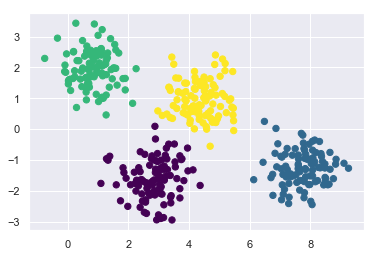

In [6]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels# Plot  
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

由上图可见： 一些点的归属应该比另一些点更明确（比如接近簇心的那些点）

而对比如黑色和黄色簇相接区域的那些点，他们到底属于哪一类？ 我相信只基于到质心的距离的分类，并不是十分能让人信服

因此，我们必须要找到一种更有通用性的模型

在此之前，我们可以用另一种形式来理解K Means：

In [7]:

from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

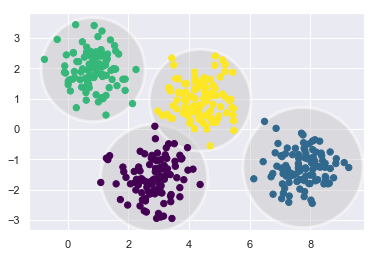

In [8]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

其实每个簇新隐含了一个圆形（在高维度就是一个超空间）用来分类，而且必须是圆形的（因为k-means的分配点的方式）

假设我们变换一下数据，会发现kmeans在这种数据集上表现的很糟糕：

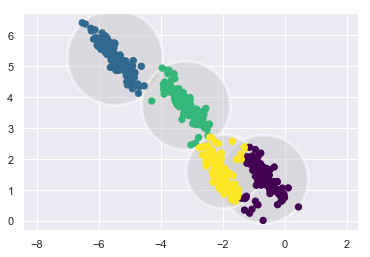

In [9]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

一些intuitive的改进：

1）比较每个点到所有簇中信的距离来度量不确定性，而不仅仅是找出最近距离的簇

2）将簇的边界从原型放宽的椭圆形

# Generalized E-M Algorithm ： Gaussian Mixture Model

在轮廓很明确的数据集上 GMM与Kmeans 结果相似：


c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

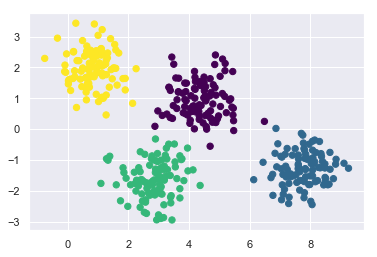

In [10]:
from sklearn.mixture import GMM
gmm = GMM(n_components = 4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0],X[:,1],cmap='viridis',c=labels,s=40)

但GMM有一个隐含的概率模型-- 因此他可以找到簇分配的概率结果 --predict_proba()

In [11]:
probs = gmm.predict_proba(X)
print(probs[:10].round(2))

[[ 0.52  0.48  0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 1.    0.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    1.    0.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.99  0.    0.01  0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]


c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


我们可以将这个不确定可视化，用每个点的大小体现预测的不确定性： 可见在簇交际区域的点很小，体现了高度不确定性

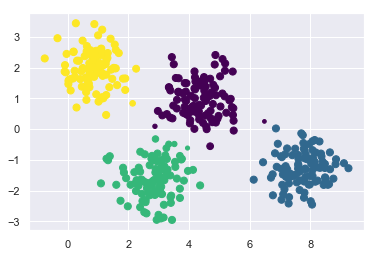

In [12]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

Choose starting guesses for the location and shape

Repeat until converged:

E-step: for each point, find weights encoding the probability of membership in each cluster
M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

再去用GMM可视化一下之前KMeans的例子：

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

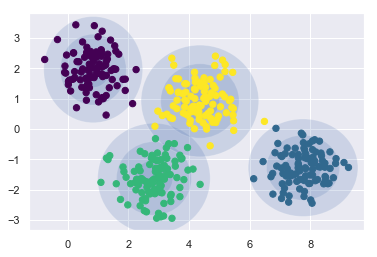

In [15]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

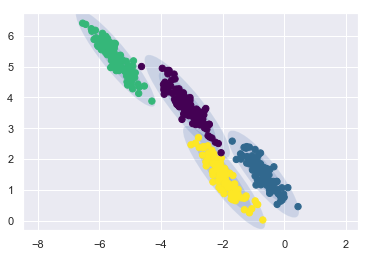

In [16]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

可见解决了之前KMeans存在的两个问题！

### 选择协方差的类型

GMM model 有一个 hyperparameter: covariance_type
    
    1) = 'diag' : 椭圆边界的主轴与坐标轴平行
        
    2） = ‘spherical' : 约束簇的形状，让所有维度相等，和kmeans的结果类似
    
    3） = ’full‘ ： 适用于高纬度数据，允许每个簇在任意方向上用椭圆建模

# GMM as Density Estimation

虽然GMM算作聚类算法, 但是他本质是一个密度估计的算法； 从技术角度来说，一个GMM的拟合结果其实是描述数据分布的生成概率模型

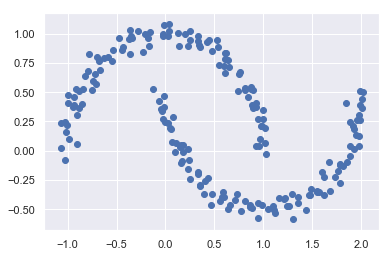

In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200,noise=.05,random_state = 0)
plt.scatter(Xmoon[:,0],Xmoon[:,1])

如果根据intuition，我们会用 k = 2来拟合我们的GMM:


c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

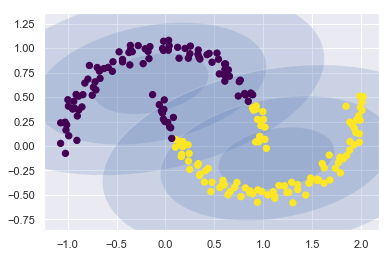

In [15]:
gmm2 = GMM(n_components = 2 ,covariance_type = 'full', random_state = 0)
plot_gmm(gmm2,Xmoon)

如上图：这样的建模方式其实并无卵用， 如果要找两个月亮间的距离（结构）上的模式，应该尝试距离类聚类或者流形学习

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

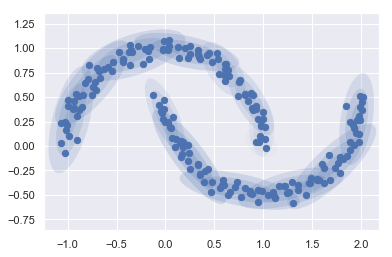

In [18]:
#尝试一下别的参数：
gmm16 = GMM(n_components = 16, covariance_type = 'full', random_state = 0)
plot_gmm(gmm16,Xmoon,label=False)

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

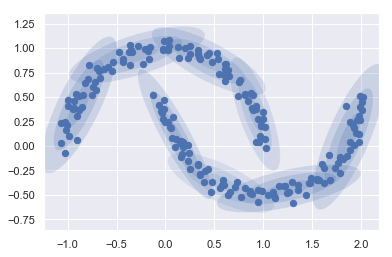

In [19]:
#尝试一下别的参数：
gmm8 = GMM(n_components = 8, covariance_type = 'full', random_state = 0)
plot_gmm(gmm8,Xmoon,label=False)

显然比n=2更接近，这里采用的16or8不是说为了找到数据的分割的簇，而是为了对数据的总体分布建模---this is the meaning of generative model----GMM可以为我们生成新的，与输入数据类似的随机分布函数

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.


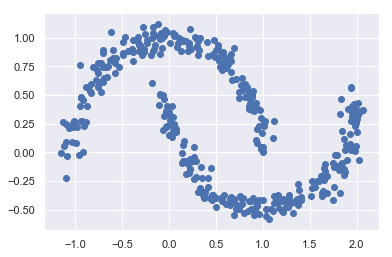

In [20]:
Xnew = gmm16.sample(400,random_state = 42)
plt.scatter(Xnew[:,0],Xnew[:,1])

如上图所示，这400个点是我们用之前的数据训练出来的模型去随机创造的400个点的分布

### How many components do we need for GMM?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC)赤池信息量准则 or the Bayesian information criterion (BIC)贝叶斯信息准测. Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

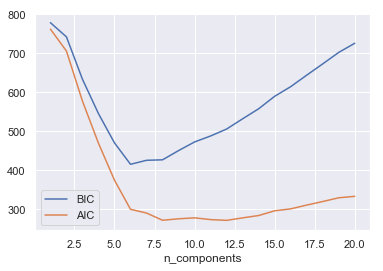

In [21]:
#灵活运用列表表达式减少代码复杂度
n_components = np.arange(1,21)
models = [GMM(n,covariance_type = 'full',random_state = 0).fit(Xmoon) for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

当AIC或BIC最小时的n是最优的n, 最终结果取决于我们更希望使用哪一种近似。由图可见：大概选择在n = 6-12之间比较合适

注意： 成分数量的选择度量的是GMM作为一个密度估计器 而不是作为聚类算法的性能；；

# Example: GMM for Generating New Data

这次我们用使用的手写数据集生成新的手写数字

In [22]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

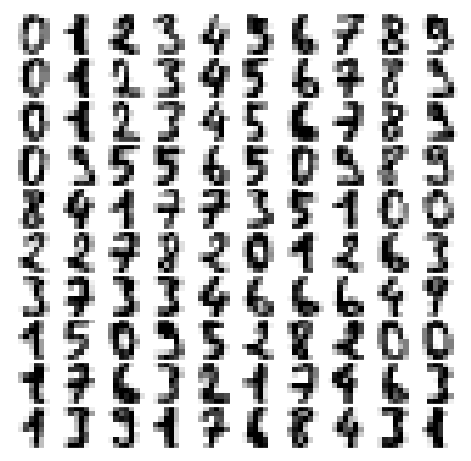

In [23]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

64维的数据对于GMM来说可能不太容易收敛，所以先使用一个降维算法降低维度 （PCA）： 用41维来保留 99%的方差

In [24]:
from sklearn.decomposition import PCA
pca = PCA(0.99,whiten =True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\sit

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationW

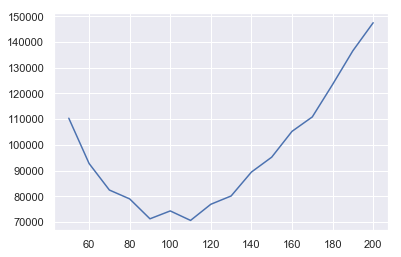

In [25]:
n_components = np.arange(50,210,10)
models = [GMM(n,covariance_type='full',random_state = 0) for n in n_components]

aics = [model.fit(data).aic(data) for model in models]

plt.plot(n_components,aics)

由上图可见  when  n = 110 we get best fitting result

In [26]:
gmm = GMM(n_components =110, covariance_type = 'full',random_state = 0)
gmm.fit(data)
print(gmm.converged_ == True)

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=Deprec

True


In [27]:
data_new = gmm.sample(100, random_state = 0 )
data_new.shape

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.


(100, 41)

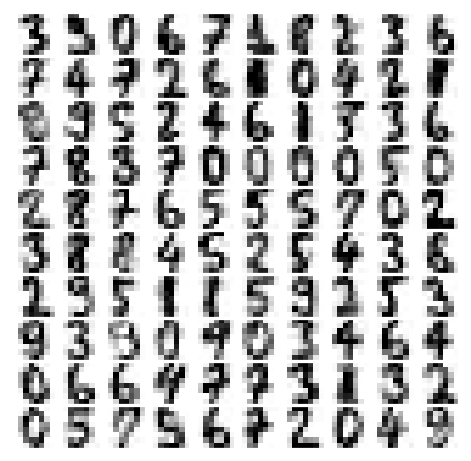

In [28]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

由上可见： 我们的gmm生成的手写数字和原生的数据的可视化之后看起来没有很大差别